> Brian is a simulator for spiking neural networks. It is written in the Python programming language and is available on almost all platforms. We believe that a simulator should not only save the time of processors, but also the time of scientists. Brian is therefore designed to be easy to learn and use, highly flexible and easily extensible.

source: [docs](https://brian2.readthedocs.io)

**Aims of this tutorial:**
1. Learn the basics of how to use Brian
2. Show you some use cases so that you can make up your own mind on whether Brian is easy to use and flexible!

**Resources:**

* Homepage: https://briansimulator.org/
* Documentation: https://brian2.readthedocs.io
* Discourse: https://brian.discourse.group/
* GitHub: https://github.com/brian-team/brian2
* eLife paper by Brian developers: https://elifesciences.org/articles/47314#abstract

In [13]:
from brian2 import *

# 1. Brian basics

## 1.1 Brian unit system

Brian always checks units! This helps to avoid a lot of errors.

>"All of the basic SI units can be used (volt, amp, etc.) along with all the standard prefixes (m=milli, p=pico, etc.), as well as a few special abbreviations like `mV` for millivolt, `pF` for picofarad, etc."

Source: [docs](https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html)

In [14]:
# combining units works as expected
10*nA*5*Mohm

50. * mvolt

In [15]:
# If you try something wrong, it gives a  a DimensionMismatchError!
# 5*amp+10*volt

Please try out some of your own unit operations!

## 1.2 Defining neuron models

Example taken from [docs](https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html)

### A very simple neuron

$$\tau_m \frac{dv}{dt} = 1-v $$

In Brian, we give the differential equations as strings:

In [16]:
start_scope() # This makes sure that previously created Brian objects
              # are not used in next simulation run.
              # Mostly used in notebooks.

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1 
'''
# Here the :1 means that v is unitless. 
# Even if we want to a use unitless dynamic variable, have to explicitly tell this to Brian!

To create a neuron (even if it is just one) we use the `NeuronGroup` class. The `StateMonitor` allows us to record during the simulation.


In [17]:
G = NeuronGroup(1, eqs, method='exact')
M = StateMonitor(G, 'v', record=True) 
run(50*ms)

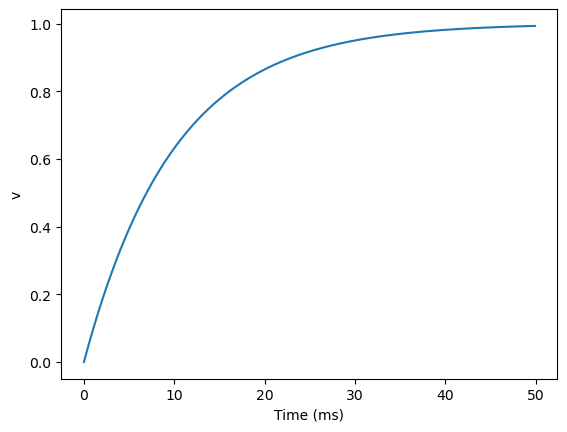

In [18]:
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

### Now make it spike

We can add simple conditions to make the neuron spike. Spikes are recorded with the `SpikeMonitor` class.

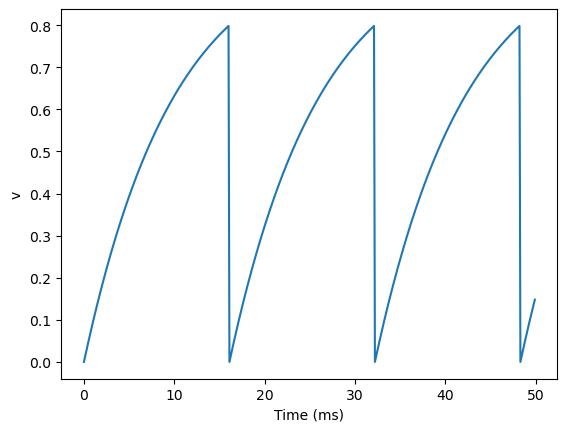

In [19]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

M = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)


run(50*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

In [20]:
print('Spike times: %s' % spikemon.t[:])

Spike times: [16.  32.1 48.2] ms


**Exercise 2:** Please modify the code above. Can you increase or decrease the firing frequency? Can you add a refractory period of 5 ms using the `refractory` keyword?

### Adding synapses

To connect neurons we use a `Synapses(source, target, ...)` object. Here we use a very simple delta synapse. The syntax `on_pre='v_post += 0.2'` means that when the presynaptic neuron spikes, the postsynaptic `v` is increased by 0.2. 

In [21]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0]
G.tau = [10, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

M = StateMonitor(G, 'v', record=True)

run(100*ms)

WARNING    'tau' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


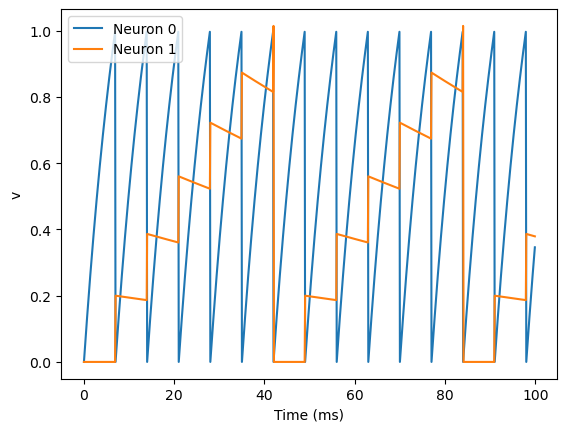

In [22]:
plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();

**Exercise 3:** Please modify the code above:
1. Change the synapse to an inibitory delta synapse.
2. Initialize the neurons at different starting `v`. 
3. Get the neurons to synchronize.

# 2. Flexibility of Brian

Here are a bunch of examples to show different things that you can do with Brian. Don't worry if you cannot get through all of them!

Examples can be found in Brian's documentation: https://brian2.readthedocs.io/en/stable/examples/index.html

## 2.1 Adding noise to a simulation

Example from: https://brian2.readthedocs.io/en/stable/resources/tutorials/1-intro-to-brian-neurons.html

In modelling, we often add a random element to capture one of the many sources of neural noise. For example, this can help us understand if the phenomenon we are studying is robust to realistic levels of noise.

First, an example without noise. Here, we change `v0` for different, uncoupled neurons to see how their frequency depends on this parameter.

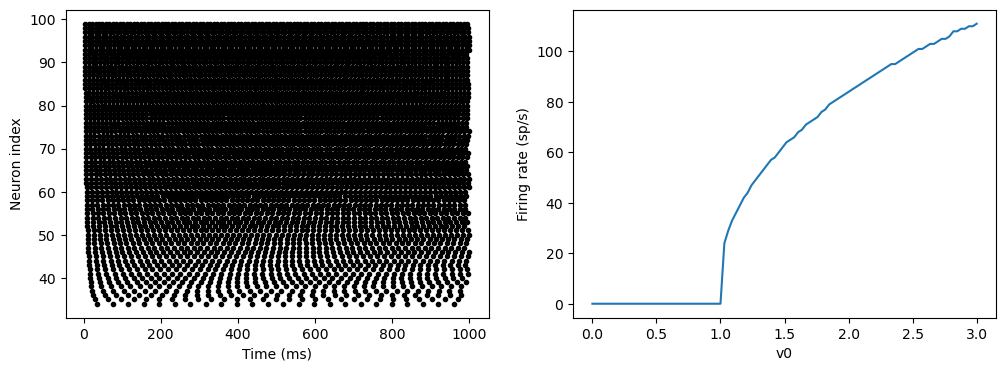

In [23]:
start_scope()

N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms

eqs = '''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
M = SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

In Brian, it is realtively easy to add a random element. For this, we add the `xi` symbol in our differential equation. This is a "stochastic differential", but we can think of it as a Gaussian random variable with mean 0 and standard deviation 1. 
To account for how the stochastic differential scales with time, we multiply `xi` with `tau**-0.5`. Additionally, we have to change the integration method to one that can deal with the stochastic differential.

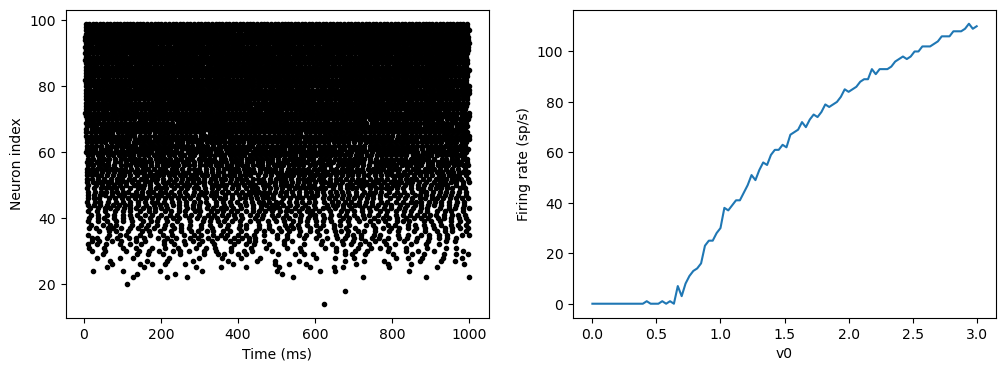

In [24]:
start_scope()

N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms
sigma = 0.2

eqs = '''
dv/dt = (v0-v)/tau+sigma*xi*tau**-0.5 : 1 (unless refractory)
v0 : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='euler')
M = SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

**Suggested exercise**: Modify the code above to increase and decrease the noise strength. The shape of the firing rate/v0 curve has qualitatively changed compared to the noise-free case. Why is this the case?

## 2.2 Example gap junctions

Example from: https://brian2.readthedocs.io/en/latest/examples/synapses.gapjunctions.html

Next to chemical synapses, nervous systems also contains electrical synapses. For example, gap junctions are a form of intercellular connection that allow direct current flow. In Brian, we can implement these, using a Synapse object. Instead of using the `on_pre` syntax as before, we use a [summed variable](https://brian2.readthedocs.io/en/stable/user/synapses.html#summed-variables).

In [25]:
start_scope()

n = 10
v0 = 1.05
tau = 10*ms

eqs = '''
dv/dt = (v0 - v + Igap) / tau : 1
Igap : 1 # gap junction current
'''

neurons = NeuronGroup(n, eqs, threshold='v > 1', reset='v = 0',
                      method='exact')
neurons.v = 'i * 1.0 / (n-1)'
trace = StateMonitor(neurons, 'v', record=[0, 5])

S = Synapses(neurons, neurons, '''
             w : 1 # gap junction conductance
             Igap_post = w * (v_pre - v_post) : 1 (summed)
             ''')
S.connect()
S.w = .02

run(500*ms)

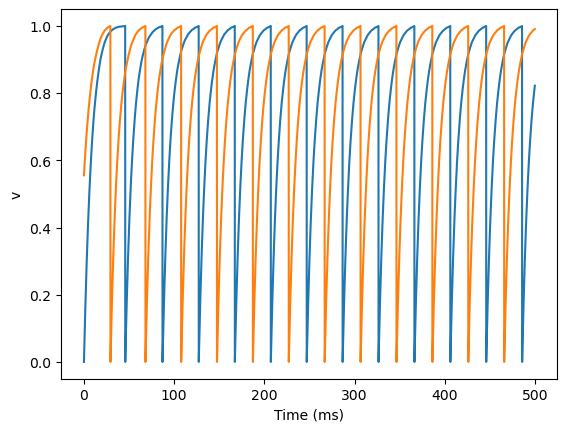

In [26]:
plot(trace.t/ms, trace[0].v)
plot(trace.t/ms, trace[5].v)
xlabel('Time (ms)')
ylabel('v')
show()

**Suggested exercise**: Reduce the number of neurons to 4. Change the `StateMonitor`, so that it records from all 4 neurons and include all their voltage traces in the plot. What happens if you increase the coupling strength?

## 2.3 Example conductance-based neuron model

Example from: https://brian2.readthedocs.io/en/stable/examples/frompapers.Wang_Buszaki_1996.html

So far, all the models we looked at were very simple Integrate-And-Fire models. Here is an example of a Hodgkin-Huxley type model, that models up- and down-stroke of the action potential without resets.

Note, how this example uses the [`exprel` function](https://brian2.readthedocs.io/en/stable/examples/advanced.exprel_function.html) that Brian provides to increase numerical accuracy in rate equations.

In [27]:
start_scope()

defaultclock.dt = 0.01*ms

Cm = 1*uF # /cm**2
Iapp = 2*uA
gL = 0.1*msiemens
EL = -65*mV
ENa = 55*mV
EK = -90*mV
gNa = 35*msiemens
gK = 9*msiemens

eqs = '''
dv/dt = (-gNa*m**3*h*(v-ENa)-gK*n**4*(v-EK)-gL*(v-EL)+Iapp)/Cm : volt
m = alpha_m/(alpha_m+beta_m) : 1
alpha_m = 0.1/mV*10*mV/exprel(-(v+35*mV)/(10*mV))/ms : Hz
beta_m = 4*exp(-(v+60*mV)/(18*mV))/ms : Hz
dh/dt = 5*(alpha_h*(1-h)-beta_h*h) : 1
alpha_h = 0.07*exp(-(v+58*mV)/(20*mV))/ms : Hz
beta_h = 1./(exp(-0.1/mV*(v+28*mV))+1)/ms : Hz
dn/dt = 5*(alpha_n*(1-n)-beta_n*n) : 1
alpha_n = 0.01/mV*10*mV/exprel(-(v+34*mV)/(10*mV))/ms : Hz
beta_n = 0.125*exp(-(v+44*mV)/(80*mV))/ms : Hz
'''

neuron = NeuronGroup(1, eqs, method='exponential_euler')
neuron.v = -70*mV
neuron.h = 1
M = StateMonitor(neuron, 'v', record=0)

run(100*ms, report='text')

WARNING    'n' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 10. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 100. ms
100. ms (100%) simulated in < 1s


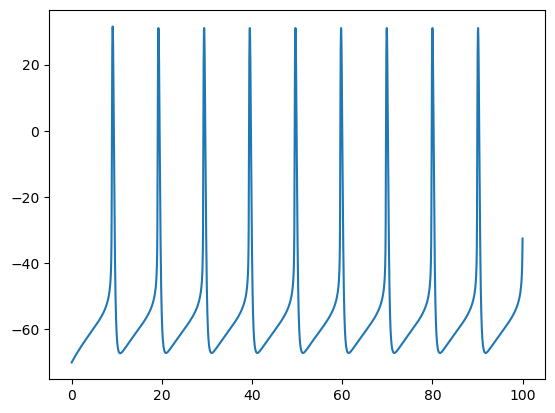

In [28]:
plot(M.t/ms, M[0].v/mV)
show()

**Suggested exercise**: What happens if you change the maximal sodium conductance `gNa`?

## 2.4 A synapse with short term plasticity

Example from https://brian2.readthedocs.io/en/latest/examples/frompapers.Tsodyks_Pawelzik_Markram_1998.html

It creates figure 1 A-C of this publication: M. Tsodyks, K. Pawelzik, H. Markram Neural Networks with Dynamic Synapses Neural Computation 10, 821–835 (1998)

https://doi.org/10.1162/089976698300017502

In [29]:
start_scope()

def get_neuron(tau_mem, R_in):
    """
    tau_mem -- membrane time constant
    R_in -- input resistance
    """
    neuron = NeuronGroup(1,
                         """
                         tau_mem : second
                         I_syn : ampere
                         R_in : ohm
                         dv/dt = -v/tau_mem + (R_in*I_syn)/tau_mem : volt
                         """,
                         method="exact")

    neuron.tau_mem = tau_mem
    neuron.R_in = R_in

    return neuron


def get_synapses(stimulus, neuron, tau_inact, A_SE, U_SE, tau_rec, tau_facil=None):
    """
    stimulus -- input stimulus
    neuron -- target neuron
    tau_inact -- inactivation time constant
    A_SE -- absolute synaptic strength
    U_SE -- utilization of synaptic efficacy
    tau_rec -- recovery time constant
    tau_facil -- facilitation time constant (optional)
    """

    synapses_eqs = """
    dx/dt =  z/tau_rec   : 1 (clock-driven) # recovered
    dy/dt = -y/tau_inact : 1 (clock-driven) # active
    A_SE : ampere
    U_SE : 1
    tau_inact : second
    tau_rec : second
    z = 1 - x - y : 1 # inactive
    I_syn_post = A_SE*y : ampere (summed)
    """

    if tau_facil:
        synapses_eqs += """
        du/dt = -u/tau_facil : 1 (clock-driven)
        tau_facil : second
        """

        synapses_action = """
        u += U_SE*(1-u)
        y += u*x # important: update y first
        x += -u*x
        """
    else:
        synapses_action = """
        y += U_SE*x # important: update y first
        x += -U_SE*x
        """

    synapses = Synapses(stimulus,
                        neuron,
                        model=synapses_eqs,
                        on_pre=synapses_action,
                        method="exponential_euler")
    synapses.connect()

    # start fully recovered
    synapses.x = 1

    synapses.tau_inact = tau_inact
    synapses.A_SE = A_SE
    synapses.U_SE = U_SE
    synapses.tau_rec = tau_rec

    if tau_facil:
        synapses.tau_facil = tau_facil

    return synapses


def get_stimulus(start, stop, frequency):
    """
    start -- start time of stimulus
    stop -- stop time of stimulus
    frequency -- frequency of stimulus
    """

    times = np.arange(start / ms, stop / ms, 1 / (frequency / Hz) * 1e3) * ms
    stimulus = SpikeGeneratorGroup(1, [0] * len(times), times)

    return stimulus


parameters = {
    "A": {
        "neuron": {"tau_mem": 40 * ms,
                   "R_in": 100*Mohm},
        "synapse": {
            "tau_inact": 3 * ms,
            "A_SE": 250 * pA,
            "tau_rec": 800 * ms,
            "U_SE": 0.6, # 0.5 from publication does not match plot
        },
        "stimulus": {"start": 100 * ms,
                     "stop": 1100 * ms,
                     "frequency": 20 * Hz},
        "simulation": {"duration": 1200 * ms},
        "plot": {
            "title": "A) D - 20 Hz",
            "ylim": [0, 1],
            "xlim": [0, 1200],
            "xtickstep": 200,
        },
    },
    "B": {
        "neuron": {"tau_mem": 60 * ms,
                   "R_in": 1*Gohm},
        "synapse": {
            "tau_inact": 1.5 * ms,
            "A_SE": 1540 * pA,
            "tau_rec": 130 * ms,
            "U_SE": 0.03,
            "tau_facil": 530 * ms,
        },
        "stimulus": {"start": 100 * ms,
                     "stop": 1100 * ms,
                     "frequency": 20 * Hz},
        "simulation": {"duration": 1200 * ms},
        "plot": {
            "title": "B) F - 20 Hz",
            "ylim": [0, 14.9],
            "xlim": [0, 1200],
            "xtickstep": 200,
        },
    },
    "C": {
        "neuron": {"tau_mem": 60 * ms,
                   "R_in": 1*Gohm},
        "synapse": {
            "tau_inact": 1.5 * ms,
            "A_SE": 1540 * pA,
            "tau_rec": 130 * ms,
            "U_SE": 0.03,
            "tau_facil": 530 * ms,
        },
        "stimulus": {"start": 100 * ms,
                     "stop": 375 * ms,
                     "frequency": 70 * Hz},
        "simulation": {"duration": 500 * ms},
        "plot": {
            "title": "C) F - 70 Hz",
            "ylim": [0, 20],
            "xlim": [0, 500],
            "xtickstep": 50,
        },
    },
}

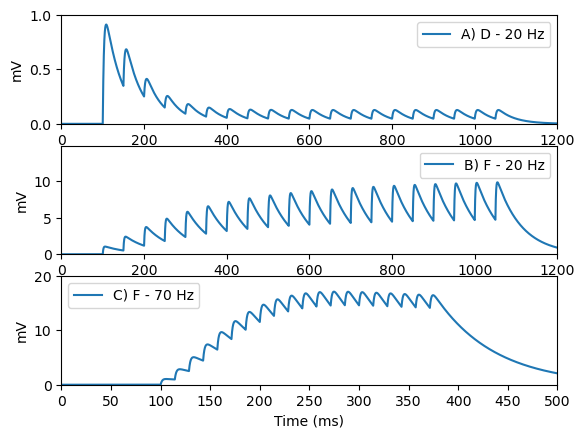

In [30]:
fig, axes = plt.subplots(3)

for ax, (panel, p) in zip(axes, parameters.items()):

    neuron = get_neuron(**p["neuron"])
    stimulus = get_stimulus(**p["stimulus"])
    synapses = get_synapses(stimulus, neuron, **p["synapse"])

    state_monitor_neuron = StateMonitor(neuron, ["v"], record=True)

    run(p["simulation"]["duration"])

    ax.plot(
        state_monitor_neuron.t / ms,
        state_monitor_neuron[0].v / mV,
        label=p["plot"]["title"],
    )

    ax.set_xlim(*p["plot"]["xlim"])
    ax.set_ylim(*p["plot"]["ylim"])
    ax.set_ylabel("mV")
    ax.set_xlabel("Time (ms)")

    ax.set_xticks(
        np.arange(
            p["plot"]["xlim"][0],
            p["plot"]["xlim"][1] + p["plot"]["xtickstep"],
            p["plot"]["xtickstep"],
        )
    )

    ax.legend()